# For archisen, classify leaf images

This uses keras, which is a wrapper script of tensorflow since tensorflow is user-unfriendly. Keras works well for most applications.

Model : Classify healthy/diseased leafs from plants. 

The model modify a pre-trained inception3 network for our use also called transfer learning. The inception3 network is a network that performed extremely well in the imagenet competition, which aims to classify objects according to 1000 classes. The image classfication competition has been discontinued since these models perform better than human accuracy. We will use the inception3 model for transfer learning since this gives fast preliminary results.

Transfer learning is a tool whereby a trained network is re-engineered for a new purpose. This involves keeping the pre-trained weights constant and chopping off the final dense layer which contains 1000 image net classes. We will add another layer to predict the healthy/diseased leafs and only train this layer. 

Why this will work is because the pre-trained network has already learnt useful features of 1000 different image classes, we will learn to use these features for our dense layer to predict healthy/disease plants. 





In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gzip

In [4]:
skip = 1 #increase this to reduce sample size if low memory
c0 = np.load(gzip.GzipFile('train/c_30.npy.gz'))[::skip] # tomato late blight
c1 = np.load(gzip.GzipFile('train/c_31.npy.gz'))[::skip] # Tomato leaf mold 
c2 = np.load(gzip.GzipFile('train/c_32.npy.gz'))[::skip] # Septrio leaf spot
c3 = np.load(gzip.GzipFile('train/c_37.npy.gz'))[::skip] # healthy
y0 = np.array([[1,0,0,0],]*c0.shape[0]) #one hot encoded labels
y1 = np.array([[0,1,0,0],]*c1.shape[0])
y2 = np.array([[0,0,1,0],]*c2.shape[0])
y3 = np.array([[0,0,0,1],]*c3.shape[0])

random numbers: 552 17 219 158
random numbers: 534 8 90 374
random numbers: 406 13 545 624
random numbers: 532 144 554 465
random numbers: 218 175 220 352
random numbers: 145 328 97 484


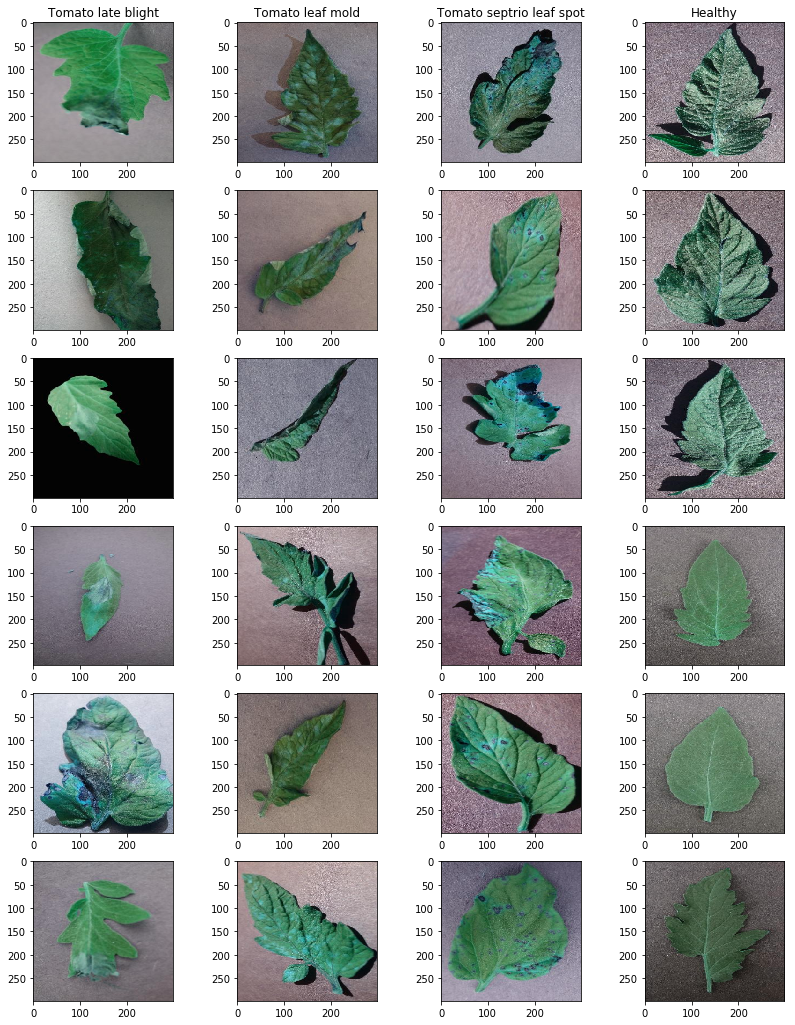

In [9]:
# random plot figures
if True:
    f, ax = plt.subplots(6,4,figsize=(14,18))
    for i in range(0,6):
        a,b = np.random.randint(0,len(c0)),np.random.randint(0,len(c1)) #random generator
        c,d = np.random.randint(0,len(c3)),np.random.randint(0,len(c3)) #random generator
        ax[i,0].imshow(c0[a]);ax[i,1].imshow(c1[b]);ax[i,2].imshow(c2[c]);ax[i,3].imshow(c3[d])
        print 'random numbers:',a,b,c,d
    ax[0,0].set_title('Tomato late blight')
    ax[0,1].set_title('Tomato leaf mold')
    ax[0,2].set_title('Tomato septrio leaf spot')
    ax[0,3].set_title('Healthy')
    plt.show()    

In [10]:
# concateneate all classes together
X ,y = np.concatenate([c0,c1,c2,c3],axis=0), np.concatenate([y0,y1,y2,y3],axis=0)
del c0,c1,c2,c3
del y0,y1,y2,y3 #clear RAM

In [11]:
from inception_v3_archisen import InceptionV3  #IF YOU HAVE PROBLEMS PLEASE MESSAGE ME

Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


In [12]:
import keras

In [13]:
from keras.layers import Input
Input_model = Input((299,299,3))  #299 can be anynumber or even None if undefined
Incept_model = InceptionV3(include_top=False, #chop of top
                weights='imagenet', #get pretrained weights
                input_tensor=Input_model, #ignore
                input_shape=None, #ignore
                pooling=None, #ignore
                classes=1000) # classes: optional number only if top is true

# Below is what inception does in the middle layers - good to know, but not crucial. Treat it as a black box first.... 
ie. it does CNN stuff. 

In [14]:
Incept_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [15]:
output = Incept_model.output
output # shape of tensor is  (batch_size, Length,Width, Channels) 

<tf.Tensor 'mixed10/concat:0' shape=(?, 8, 8, 2048) dtype=float32>

In [25]:
output2 = keras.layers.GlobalAveragePooling2D()(output) 
output2 #global max pooling finds the max point in each channel. Frequently used, max finds the strongest signal. Average is also reasonable

<tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(?, 2048) dtype=float32>

In [31]:
output2 = keras.layers.Dropout(0.5)(output2)
output3 = keras.layers.Dense(96,activation='relu') (output2) # dense neural network with 50 layers
output4 = keras.layers.Dense(4, activation="softmax") (output3) # output 3 classes in probabiltites with softmax
output3,output4

(<tf.Tensor 'dense_5/Relu:0' shape=(?, 96) dtype=float32>,
 <tf.Tensor 'dense_6/Softmax:0' shape=(?, 4) dtype=float32>)

In [32]:
from keras.models import Model
model = Model(Input_model,output4) #using logits layer

In [33]:
model.compile(loss = "categorical_crossentropy",
                    optimizer = 'adam',#SGD(lr=learn_rate, momentum=momentum),
                    metrics=['categorical_crossentropy',"accuracy"])

In [34]:
model.summary() #only last two layers with 30735 and 64 parameters are trainable

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [35]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = 'transfer_model.h5'
callbacks = [
        EarlyStopping(
            monitor='val_categorical_crossentropy', 
            patience=3, # stop training at 3
            verbose=0),
        
        ModelCheckpoint(
            model_path , 
            monitor='val_categorical_crossentropy', 
            save_best_only=True, 
            verbose=0)
    ]

In [22]:
X_tr ,y_tr = X[0::2,], y[0::2,]
X_val , y_val = X[1::2,],y[1::2,]
del X ,y

In [ ]:
X_tr[0]

In [23]:
import gc
gc.collect()

0

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images
# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_tr)

In [ ]:
if False: # GPU training
    hist=model.fit_generator(datagen.flow(X_tr, y_tr,
                                     batch_size=32), 100,29, # increase it to 20-100 to get better results
                            validation_data=(X_val, y_val),
                            verbose=1,
                            callbacks=callbacks,
                            shuffle=True
                        ) #this will take 1-2 hours on CPU, 10mins on GPU

In [36]:
model.load_weights('transfer_model.h5') #trained with astar super computer for 30mins

# Model prediction

In [37]:
pred= model.predict(X_val)

In [73]:
pred2 = np.argmax(pred,1)
print  'Accuracy of test set',np.mean(pred2==np.argmax(y_val,1))
print  'Inaccurately predicted',np.sum(pred2!=np.argmax(y_val,1))
print 'Total test set size',len(pred)

Accuracy of test set 0.930950446791
Inaccurately predicted 85
Total test set size 1231


# Closer look at those which are wrongly predicted to be healthy

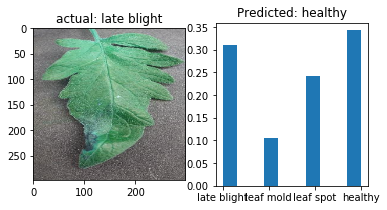

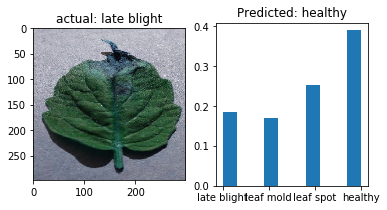

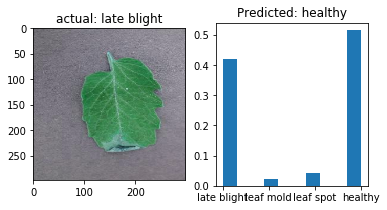

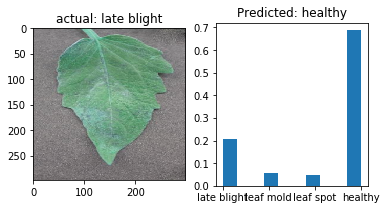

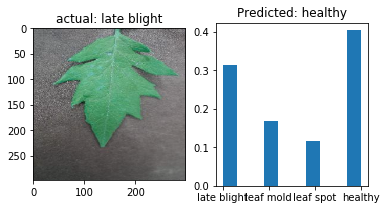

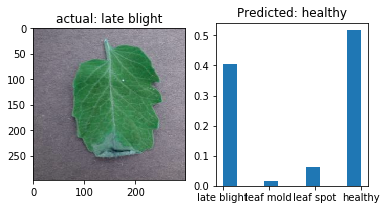

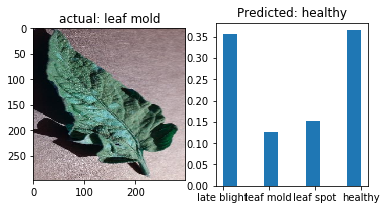

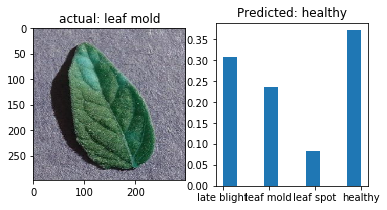

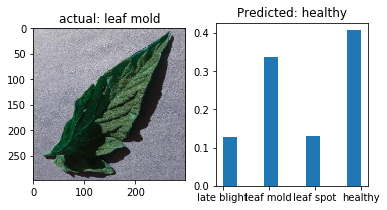

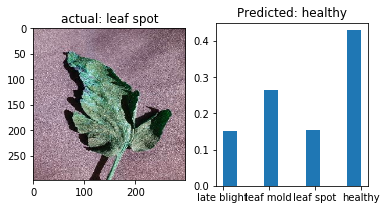

In [85]:
for i in range(0,len(pred2)):
    if pred2[i] != np.argmax(y_val,1)[i] and np.argmax(pred,1)[i]==3:
        f,ax = plt.subplots(1,2,figsize=(6,3))
        ax[0].imshow(X_val[i])
        ax[1].hist([0,1,2,3],weights=pred[i])
        ax[0].set_title('actual: '+ ['late blight','leaf mold','leaf spot','healthy'][np.argmax(y_val,1)[i]])
        ax[1].set_title('Predicted: '+ ['late blight','leaf mold','leaf spot','healthy'][np.argmax(pred,1)[i]])
        plt.sca(ax[ 1])
        plt.xticks([0,1,2,3],['late blight','leaf mold','leaf spot','healthy'])
        plt.show()

# Looking at the normal ones

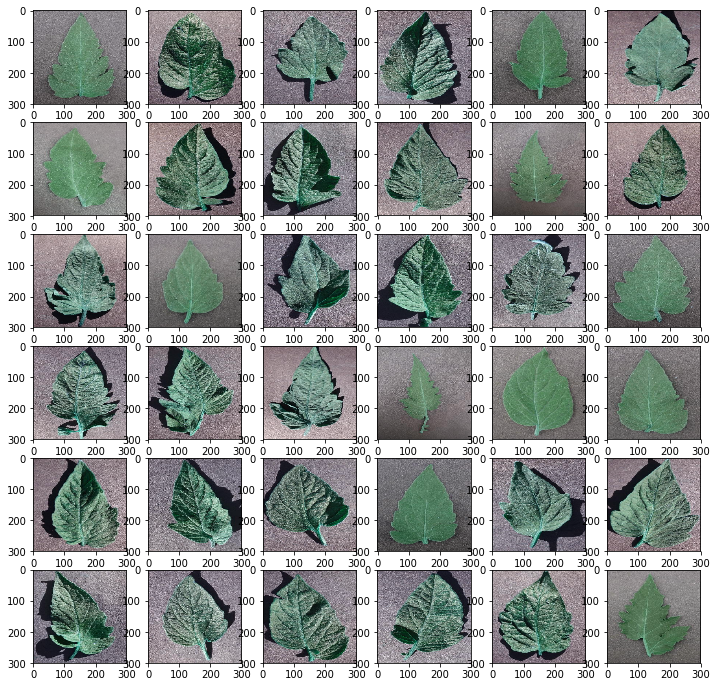

In [94]:
counter  = 0
f,ax = plt.subplots(6,6,figsize=(12,12))
for i in range(0,len(pred2)):
    if np.argmax(y_val[i]) == 3:
        ax[counter//6,counter%6].imshow(X_val[i])
        counter += 1
    if counter == 36:
        plt.show();break
        